In [1]:
import operator
from functools import reduce
from typing import List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
from pyro import poutine
from pyro.infer import (
    SVI,
    Trace_ELBO,
    TraceGraph_ELBO,
    config_enumerate,
    infer_discrete,
)
from pyro.ops.indexing import Vindex
from torch.distributions import constraints
from tqdm import tqdm

pyro.set_rng_seed(0)

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p arviz,matplotlib,numpy,pandas,pyro,torch,tqdm

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

arviz     : 0.11.2
matplotlib: 3.4.3
numpy     : 1.20.3
pandas    : 1.3.2
pyro      : 1.7.0
torch     : 1.9.0
tqdm      : 4.62.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 2ce327ff7d1c356cc46cc1e159f82e839dfb4bd4

Git branch: master



# Purpose
- Reproducing [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) to [Chapter 2 MBML Learning skills](https://mbmlbook.com/LearningSkills.html)
- Some of the trials and experiments were motivated by discusion on the [Pyro forum](https://forum.pyro.ai/t/numpyro-chapter-2-mbml/3184).

The twist:
1. we are using `pyro.__version__ == 1.7.0` instead of `0.3`
1. assume a fixed guessing probability (work on building one the first iterations of the model from the book)
2. reporduce the results for just three questions, two skills using model form [**Figure 2.17**](https://mbmlbook.com/LearningSkills_Moving_to_real_data.html) with [**Table 2.4**](https://mbmlbook.com/LearningSkills_Testing_out_the_model.html), reproduced below

|    | IsCorrect1   | IsCorrect2   | IsCorrect2   |   P(csharp) |   P(sql) |
|---:|:-------------|:-------------|:-------------|------------:|---------:|
|  0 | False        | False        | False        |       0.101 |    0.101 |
|  1 | True         | False        | False        |       0.802 |    0.034 |
|  2 | False        | True         | False        |       0.034 |    0.802 |
|  3 | True         | True         | False        |       0.561 |    0.561 |
|  4 | False        | False        | True         |       0.148 |    0.148 |
|  5 | True         | False        | True         |       0.862 |    0.326 |
|  6 | False        | True         | True         |       0.326 |    0.862 |
|  7 | True         | True         | True         |       0.946 |    0.946 |

The table above can be used to check our model, and to get us ready for the *real data*. Lets view each permutation as a data record, resulting in a table of 3 responses from 8 people, where each question either needs `skill_01`, `skill_02`, or `skill_01` and `skill_02`. The toy data is shown below:

In [5]:
expected = pd.DataFrame(
    [
        (False, False, False, 0.101, 0.101),
        (True, False, False, 0.802, 0.034),
        (False, True, False, 0.034, 0.802),
        (True, True, False, 0.561, 0.561),
        (False, False, True, 0.148, 0.148),
        (True, False, True, 0.862, 0.326),
        (False, True, True, 0.326, 0.862),
        (True, True, True, 0.946, 0.946),
    ],
    columns=["IsCorrect1", "IsCorrect2", "IsCorrect2", "P(csharp)", "P(sql)"],
)

In [6]:
responses_check = torch.tensor(
    [
        [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
        [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
    ]
)
skills_needed_check = [[0], [1], [0, 1]]

In [7]:
# row = participants' responses to each question
# column = participants
responses_check.shape

torch.Size([3, 8])

In [8]:
def model(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample("skills", dist.Bernoulli(0.5),)

    for q in pyro.plate("questions_plate", n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]]).float()
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = pyro.sample(
            "isCorrect{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

In [9]:
def guide(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    skill_p = pyro.param(
        "skill_p",
        0.5 * torch.ones(n_skills, n_participants),
        constraint=constraints.unit_interval,
    )

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample("skills", dist.Bernoulli(skill_p))

    return skills, skill_p

In [10]:
# smoke test for guide
guide(responses_check, skills_needed_check)

(tensor([[1., 0., 1., 1., 1., 0., 1., 0.],
         [1., 0., 1., 1., 1., 1., 1., 0.]]),
 tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],
        grad_fn=<ClampBackward1>))

In [11]:
adam_params = {"lr": 0.05, "betas": (0.9, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

In [12]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=Trace_ELBO())

losses, skills_svi = [], []
for _ in tqdm(range(10_000)):
    losses.append(svi.step(responses_check, skills_needed_check))
    skills_svi.append(pyro.param("skill_p"))

100%|██████████| 10000/10000 [00:40<00:00, 248.81it/s]


In [13]:
d = pyro.get_param_store()

In [14]:
res_skill_0 = torch.vstack([s[0] for s in skills_svi])
res_skill_0 = res_skill_0.detach().numpy()
res_skill_0

array([[0.51249737, 0.51249737, 0.48750263, ..., 0.51249737, 0.48750263,
        0.51249737],
       [0.5111439 , 0.5111439 , 0.4750087 , ..., 0.5249913 , 0.48885608,
        0.5249913 ],
       [0.5067726 , 0.5067726 , 0.4694806 , ..., 0.5371534 , 0.49322742,
        0.5305194 ],
       ...,
       [0.07945157, 0.940372  , 0.02209679, ..., 0.8843498 , 0.35367662,
        0.9886127 ],
       [0.07912742, 0.9399194 , 0.02226795, ..., 0.8837418 , 0.35083267,
        0.98854584],
       [0.07893684, 0.93944186, 0.02244011, ..., 0.8830483 , 0.34681496,
        0.98847884]], dtype=float32)

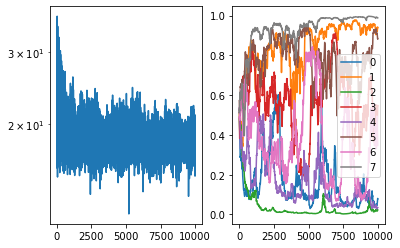

In [15]:
plt.subplot(1, 2, 1)
plt.semilogy(losses)

ax2 = plt.subplot(1, 2, 2)
for n in range(8):
    plt.plot(res_skill_0[:, n], label=str(n))

plt.legend()

In [16]:
res_skill_1 = torch.vstack([s[1] for s in skills_svi])
res_skill_1 = res_skill_1.detach().numpy()
res_skill_1

array([[0.48750263, 0.51249737, 0.51249737, ..., 0.48750263, 0.48750263,
        0.51249737],
       [0.48885608, 0.5111439 , 0.5249913 , ..., 0.4750087 , 0.48885608,
        0.5249913 ],
       [0.49322742, 0.5067726 , 0.5305194 , ..., 0.4694806 , 0.48624858,
        0.5371534 ],
       ...,
       [0.05672815, 0.00344691, 0.8466699 , ..., 0.08960518, 0.84103084,
        0.8718411 ],
       [0.05604482, 0.00341778, 0.84697336, ..., 0.08976293, 0.83969796,
        0.8731921 ],
       [0.05550299, 0.00339268, 0.84697396, ..., 0.09000763, 0.83818406,
        0.8741439 ]], dtype=float32)

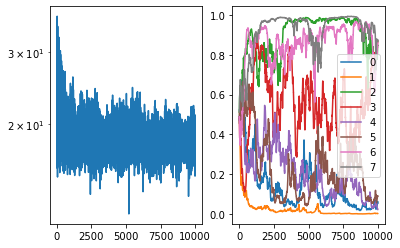

In [17]:
# same loss, skill_02
plt.subplot(1, 2, 1)
plt.semilogy(losses)

ax2 = plt.subplot(1, 2, 2)
for n in range(8):
    plt.plot(res_skill_1[:, n], label=str(n))

plt.legend()

In [18]:
expected["Trace_ELBO P(csharp)"] = res_skill_0[-1, :]
expected["Trace_ELBO P(sql)"] = res_skill_1[-1, :]

In [19]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),Trace_ELBO P(csharp),Trace_ELBO P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503
1,True,False,False,0.802,0.034,0.939442,0.003393
2,False,True,False,0.034,0.802,0.022440,0.846974
3,True,True,False,0.561,0.561,0.547225,0.868830
4,False,False,True,0.148,0.148,0.034718,0.023729
5,True,False,True,0.862,0.326,0.883048,0.090008
6,False,True,True,0.326,0.862,0.346815,0.838184
7,True,True,True,0.946,0.946,0.988479,0.874144


## Change loss to `TraceGraph_ELBO`

In [20]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=TraceGraph_ELBO())

losses, skills_svi = [], []
for _ in tqdm(range(10_000)):
    losses.append(svi.step(responses_check, skills_needed_check))
    skills_svi.append(pyro.param("skill_p"))

100%|██████████| 10000/10000 [00:41<00:00, 241.59it/s]


In [21]:
d = pyro.get_param_store()

In [22]:
res_skill_0 = torch.vstack([s[0] for s in skills_svi])
res_skill_0 = res_skill_0.detach().numpy()
res_skill_0

array([[0.51249737, 0.48750263, 0.48750263, ..., 0.48750263, 0.51249737,
        0.48750263],
       [0.51305217, 0.47510237, 0.48694786, ..., 0.47510237, 0.51305217,
        0.47510237],
       [0.5083145 , 0.47250664, 0.49168557, ..., 0.47250664, 0.5083145 ,
        0.47250664],
       ...,
       [0.01222996, 0.87851816, 0.01287001, ..., 0.8896716 , 0.40956825,
        0.90647376],
       [0.01226944, 0.8790277 , 0.0129409 , ..., 0.889001  , 0.41079435,
        0.90538126],
       [0.01231283, 0.88088167, 0.01301544, ..., 0.8881245 , 0.41336468,
        0.9042132 ]], dtype=float32)

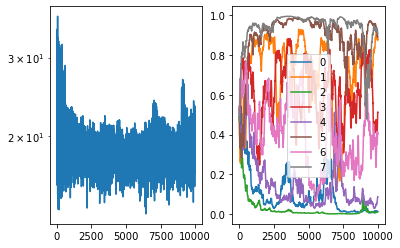

In [23]:
plt.subplot(1, 2, 1)
plt.semilogy(losses)

ax2 = plt.subplot(1, 2, 2)
for n in range(8):
    plt.plot(res_skill_0[:, n], label=str(n))

plt.legend()

In [24]:
res_skill_1 = torch.vstack([s[1] for s in skills_svi])
res_skill_1 = res_skill_1.detach().numpy()
res_skill_1

array([[0.51249737, 0.48750263, 0.51249737, ..., 0.48750263, 0.48750263,
        0.51249737],
       [0.52489763, 0.48694786, 0.52489763, ..., 0.47510237, 0.47510237,
        0.52489763],
       [0.53733253, 0.4814067 , 0.53733253, ..., 0.47250664, 0.46266747,
        0.52749336],
       ...,
       [0.18810861, 0.3519549 , 0.860762  , ..., 0.48447758, 0.9779073 ,
        0.710247  ],
       [0.18971062, 0.3566685 , 0.86149186, ..., 0.48324814, 0.97783136,
        0.7115585 ],
       [0.18910131, 0.3577212 , 0.8618516 , ..., 0.48396552, 0.9777439 ,
        0.7151459 ]], dtype=float32)

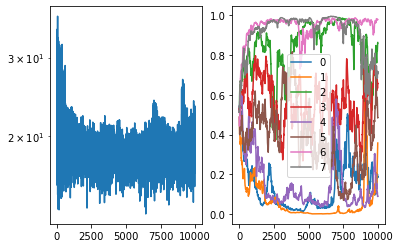

In [25]:
# same loss, skill_02
plt.subplot(1, 2, 1)
plt.semilogy(losses)

ax2 = plt.subplot(1, 2, 2)
for n in range(8):
    plt.plot(res_skill_1[:, n], label=str(n))

plt.legend()

In [26]:
expected["TraceGraph_ELBO P(csharp)"] = res_skill_0[-1, :]
expected["TraceGraph_ELBO P(sql)"] = res_skill_1[-1, :]

In [27]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),Trace_ELBO P(csharp),Trace_ELBO P(sql),TraceGraph_ELBO P(csharp),TraceGraph_ELBO P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503,0.012313,0.189101
1,True,False,False,0.802,0.034,0.939442,0.003393,0.880882,0.357721
2,False,True,False,0.034,0.802,0.022440,0.846974,0.013015,0.861852
3,True,True,False,0.561,0.561,0.547225,0.868830,0.513232,0.635577
4,False,False,True,0.148,0.148,0.034718,0.023729,0.086150,0.089866
5,True,False,True,0.862,0.326,0.883048,0.090008,0.888125,0.483966
6,False,True,True,0.326,0.862,0.346815,0.838184,0.413365,0.977744
7,True,True,True,0.946,0.946,0.988479,0.874144,0.904213,0.715146


#### Reducing Variance with Data-Dependent Baselines

In [28]:
def guide_base(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    skill_p = pyro.param(
        "skill_p",
        0.5 * torch.ones(n_skills, n_participants),
        constraint=constraints.unit_interval,
    )

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample(
                "skills",
                dist.Bernoulli(skill_p),
                infer=dict(
                    baseline={"use_decaying_avg_baseline": True, "baseline_beta": 0.9}
                ),
            )

    return skills, skill_p

In [29]:
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=model, guide=guide_base, optim=optimizer, loss=TraceGraph_ELBO()
)

losses, skills_svi = [], []
for _ in tqdm(range(10_000)):
    losses.append(svi.step(responses_check, skills_needed_check))
    skills_svi.append(pyro.param("skill_p"))

100%|██████████| 10000/10000 [00:43<00:00, 230.83it/s]


In [30]:
d = pyro.get_param_store()

In [31]:
res_skill_0 = torch.vstack([s[0] for s in skills_svi])
res_skill_0 = res_skill_0.detach().numpy()
res_skill_0

res_skill_1 = torch.vstack([s[1] for s in skills_svi])
res_skill_1 = res_skill_1.detach().numpy()
res_skill_1

expected["decay TraceGraph_ELBO P(csharp)"] = res_skill_0[-1, :]
expected["decay TraceGraph_ELBO P(sql)"] = res_skill_1[-1, :]

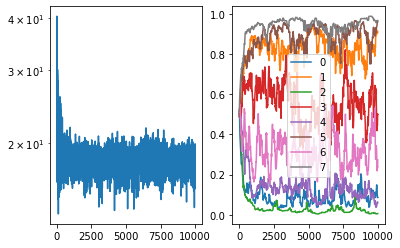

In [32]:
plt.subplot(1, 2, 1)
plt.semilogy(losses)

ax2 = plt.subplot(1, 2, 2)
for n in range(8):
    plt.plot(res_skill_0[:, n], label=str(n))

plt.legend()

In [33]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),Trace_ELBO P(csharp),Trace_ELBO P(sql),TraceGraph_ELBO P(csharp),TraceGraph_ELBO P(sql),decay TraceGraph_ELBO P(csharp),decay TraceGraph_ELBO P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503,0.012313,0.189101,0.085523,0.167065
1,True,False,False,0.802,0.034,0.939442,0.003393,0.880882,0.357721,0.907181,0.025088
2,False,True,False,0.034,0.802,0.022440,0.846974,0.013015,0.861852,0.005501,0.918040
3,True,True,False,0.561,0.561,0.547225,0.868830,0.513232,0.635577,0.500015,0.625142
4,False,False,True,0.148,0.148,0.034718,0.023729,0.086150,0.089866,0.058852,0.065720
5,True,False,True,0.862,0.326,0.883048,0.090008,0.888125,0.483966,0.960243,0.437125
6,False,True,True,0.326,0.862,0.346815,0.838184,0.413365,0.977744,0.272805,0.910495
7,True,True,True,0.946,0.946,0.988479,0.874144,0.904213,0.715146,0.965964,0.965729


## Decay experiments

In [34]:
from functools import partial
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

In [35]:
rmse = partial(mean_squared_error, squared=False)

In [36]:
metrics = {
    "mse": mean_squared_error,
    "mae": median_absolute_error,
    "r2_score": r2_score,
    "rmse": rmse,
}

In [37]:
def model_decay(
    graded_responses,
    skills_needed: List[List[int]],
    prob_mistake=0.1,
    prob_guess=0.2,
    baseline_beta=0.9,
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample("skills", dist.Bernoulli(0.5),)

    for q in pyro.plate("questions_plate", n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]]).float()
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = pyro.sample(
            "isCorrect{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )


def guide_decay(
    graded_responses,
    skills_needed: List[List[int]],
    prob_mistake=0.1,
    prob_guess=0.2,
    baseline_beta=0.9,
):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    skill_p = pyro.param(
        "skill_p",
        0.5 * torch.ones(n_skills, n_participants),
        constraint=constraints.unit_interval,
    )

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample(
                "skills",
                dist.Bernoulli(skill_p),
                infer=dict(
                    baseline={
                        "use_decaying_avg_baseline": True,
                        "baseline_beta": baseline_beta,
                    }
                ),
            )

    return skills, skill_p

In [38]:
columns = [
    "P(csharp) mse",
    "P(sql) mse",
    "P(csharp) mae",
    "P(sql) mae",
    "P(csharp) r2_score",
    "P(sql) r2_score",
    "P(csharp) rmse",
    "P(sql) rmse",
]

In [39]:
result = []
index = np.linspace(-1., 1., 20)
for baseline in index:
    pyro.clear_param_store()
    guide = partial(guide_decay, baseline_beta=baseline)
    svi = pyro.infer.SVI(
        model=model_decay, guide=guide, optim=optimizer, loss=TraceGraph_ELBO()
    )

    losses, skills_svi = [], []
    for _ in tqdm(range(5000)):
        losses.append(svi.step(responses_check, skills_needed_check))
        skills_svi.append(pyro.param("skill_p"))

    res_skill_0 = torch.vstack([s[0] for s in skills_svi])
    res_skill_0 = res_skill_0.detach().numpy()

    res_skill_1 = torch.vstack([s[1] for s in skills_svi])
    res_skill_1 = res_skill_1.detach().numpy()

    row = []
    for metric in metrics.items():
        name, score = metric
        res_00 = score(expected["P(csharp)"], res_skill_0[-1, :])
        res_01 = score(expected["P(sql)"], res_skill_1[-1, :])
        row.extend([res_00, res_01])

    result.append(tuple(row))

100%|██████████| 5000/5000 [00:21<00:00, 234.40it/s]


In [40]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),Trace_ELBO P(csharp),Trace_ELBO P(sql),TraceGraph_ELBO P(csharp),TraceGraph_ELBO P(sql),decay TraceGraph_ELBO P(csharp),decay TraceGraph_ELBO P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503,0.012313,0.189101,0.085523,0.167065
1,True,False,False,0.802,0.034,0.939442,0.003393,0.880882,0.357721,0.907181,0.025088
2,False,True,False,0.034,0.802,0.022440,0.846974,0.013015,0.861852,0.005501,0.918040
3,True,True,False,0.561,0.561,0.547225,0.868830,0.513232,0.635577,0.500015,0.625142
4,False,False,True,0.148,0.148,0.034718,0.023729,0.086150,0.089866,0.058852,0.065720
5,True,False,True,0.862,0.326,0.883048,0.090008,0.888125,0.483966,0.960243,0.437125
6,False,True,True,0.326,0.862,0.346815,0.838184,0.413365,0.977744,0.272805,0.910495
7,True,True,True,0.946,0.946,0.988479,0.874144,0.904213,0.715146,0.965964,0.965729


In [41]:
default = {}
for metric in metrics.items():
    name, score = metric
    default_res_00 = score(expected["P(csharp)"], expected["Trace_ELBO P(csharp)"])
    default_res_01 = score(expected["P(sql)"], expected["Trace_ELBO P(sql)"])
    default_res_02 = score(expected["P(csharp)"], expected["TraceGraph_ELBO P(csharp)"])
    default_res_03 = score(expected["P(sql)"], expected["TraceGraph_ELBO P(sql)"])
    default[name + "P(csharp)" + "Trace_ELBO"] = default_res_00
    default[name + "P(sql)" + "Trace_ELBO"] = default_res_01
    default[name + "P(csharp)" + "TraceGraph_ELBO"] = default_res_02
    default[name + "P(sql)" + "TraceGraph_ELBO"] = default_res_03
    print(
        f"{name:10} Trace_ELBO | P(csharp) = {default_res_00:0.4f} P(sql) = {default_res_01:0.4f} | TraceGraph_ELBO | P(csharp) = {default_res_02:0.4f} P(sql) = {default_res_03:0.4f}"
    )

mse        Trace_ELBO | P(csharp) = 0.0044 P(sql) = 0.0221 | TraceGraph_ELBO | P(csharp) = 0.0038 P(sql) = 0.0271
mae        Trace_ELBO | P(csharp) = 0.0216 P(sql) = 0.0587 | TraceGraph_ELBO | P(csharp) = 0.0548 P(sql) = 0.1019
r2_score   Trace_ELBO | P(csharp) = 0.9629 P(sql) = 0.8139 | TraceGraph_ELBO | P(csharp) = 0.9677 P(sql) = 0.7717
rmse       Trace_ELBO | P(csharp) = 0.0663 P(sql) = 0.1486 | TraceGraph_ELBO | P(csharp) = 0.0619 P(sql) = 0.1646


In [42]:
result_df = pd.DataFrame(result, columns=columns, index=index)

In [43]:
result_df

,P(csharp) mse,P(sql) mse,P(csharp) mae,P(sql) mae,P(csharp) r2_score,P(sql) r2_score,P(csharp) rmse,P(sql) rmse
-1.000000,0.154366,0.179972,0.161823,0.280820,-0.300788,-0.516559,0.392895,0.424231
-0.894737,0.005752,0.002992,0.054434,0.037699,0.951529,0.974790,0.075843,0.054697
-0.789474,0.006550,0.004614,0.051462,0.054989,0.944803,0.961121,0.080934,0.067925
-0.684211,0.011145,0.013966,0.060275,0.070563,0.906088,0.882314,0.105568,0.118178
-0.578947,0.002241,0.010523,0.030085,0.036965,0.981115,0.911326,0.047340,0.102582
-0.473684,0.001989,0.003952,0.026739,0.050968,0.983243,0.966702,0.044593,0.062862
-0.368421,0.007890,0.004048,0.045709,0.060752,0.933516,0.965891,0.088824,0.063622
-0.263158,0.010712,0.004379,0.071025,0.030088,0.909736,0.963104,0.103498,0.066171
-0.157895,0.004703,0.002714,0.038288,0.027321,0.960373,0.977131,0.068575,0.052096
-0.052632,0.006960,0.012121,0.078922,0.031702,0.941348,0.897858,0.083429,0.110097


<AxesSubplot:>

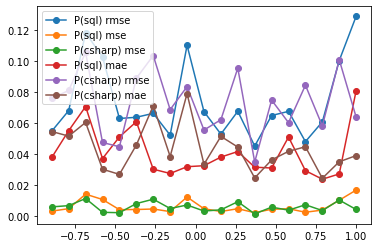

In [44]:
result_df[list(set(columns) - set(["P(csharp) r2_score", "P(sql) r2_score"]))].iloc[1:].plot(
    marker="o"
)

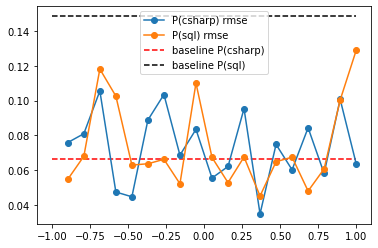

In [45]:
result_df[["P(csharp) rmse", "P(sql) rmse"]].iloc[1:].plot(marker="o")
plt.hlines(default["rmseP(csharp)Trace_ELBO"], -1., 1., color="r", linestyles="--", label="baseline P(csharp)")
plt.hlines(default["rmseP(sql)Trace_ELBO"], -1., 1., color="k", linestyles="--", label="baseline P(sql)")
plt.legend()

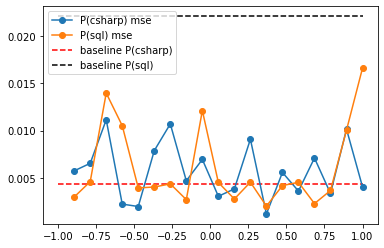

In [46]:
result_df[["P(csharp) mse", "P(sql) mse"]].iloc[1:].plot(marker="o")
plt.hlines(default["mseP(csharp)Trace_ELBO"], -1., 1., color="r", linestyles="--", label="baseline P(csharp)")
plt.hlines(default["mseP(sql)Trace_ELBO"], -1., 1., color="k", linestyles="--", label="baseline P(sql)")
plt.legend()

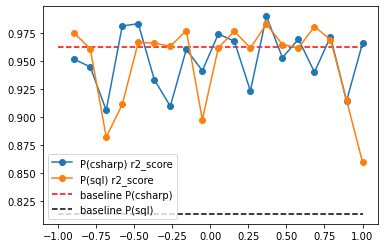

In [47]:
result_df[["P(csharp) r2_score", "P(sql) r2_score"]].iloc[1:].plot(marker="o")
plt.hlines(default["r2_scoreP(csharp)Trace_ELBO"], -1., 1., color="r", linestyles="--", label="baseline P(csharp)")
plt.hlines(default["r2_scoreP(sql)Trace_ELBO"], -1., 1., color="k", linestyles="--", label="baseline P(sql)")
plt.legend()

### Using the best param

In [48]:
def guide_base(
    graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2
):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    skill_p = pyro.param(
        "skill_p",
        0.5 * torch.ones(n_skills, n_participants),
        constraint=constraints.unit_interval,
    )

    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample(
                "skills",
                dist.Bernoulli(skill_p),
                infer=dict(
                    baseline={"use_decaying_avg_baseline": True, "baseline_beta": 0.368421}
                ),
            )

    return skills, skill_p

In [49]:
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=model, guide=guide_base, optim=optimizer, loss=TraceGraph_ELBO()
)

losses, skills_svi = [], []
for _ in tqdm(range(10_000)):
    losses.append(svi.step(responses_check, skills_needed_check))
    skills_svi.append(pyro.param("skill_p"))

100%|██████████| 10000/10000 [00:41<00:00, 242.92it/s]


In [50]:
res_skill_0 = torch.vstack([s[0] for s in skills_svi])
res_skill_0 = res_skill_0.detach().numpy()
res_skill_0

res_skill_1 = torch.vstack([s[1] for s in skills_svi])
res_skill_1 = res_skill_1.detach().numpy()
res_skill_1

expected["best decay TraceGraph_ELBO P(csharp)"] = res_skill_0[-1, :]
expected["best decay TraceGraph_ELBO P(sql)"] = res_skill_1[-1, :]

In [51]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),Trace_ELBO P(csharp),Trace_ELBO P(sql),TraceGraph_ELBO P(csharp),TraceGraph_ELBO P(sql),decay TraceGraph_ELBO P(csharp),decay TraceGraph_ELBO P(sql),best decay TraceGraph_ELBO P(csharp),best decay TraceGraph_ELBO P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503,0.012313,0.189101,0.085523,0.167065,0.159373,0.212234
1,True,False,False,0.802,0.034,0.939442,0.003393,0.880882,0.357721,0.907181,0.025088,0.754841,0.028081
2,False,True,False,0.034,0.802,0.022440,0.846974,0.013015,0.861852,0.005501,0.918040,0.028313,0.803002
3,True,True,False,0.561,0.561,0.547225,0.868830,0.513232,0.635577,0.500015,0.625142,0.577625,0.668692
4,False,False,True,0.148,0.148,0.034718,0.023729,0.086150,0.089866,0.058852,0.065720,0.134006,0.072838
5,True,False,True,0.862,0.326,0.883048,0.090008,0.888125,0.483966,0.960243,0.437125,0.834419,0.349507
6,False,True,True,0.326,0.862,0.346815,0.838184,0.413365,0.977744,0.272805,0.910495,0.359426,0.893284
7,True,True,True,0.946,0.946,0.988479,0.874144,0.904213,0.715146,0.965964,0.965729,0.951077,0.949261
